# Experimenting with Matrix Factorization and the MovieLens Dataset

This notebook will allow you to experiment with the parameters of matrix factorization with the MovieLens dataset. I'm using the 100k dataset, and storing it in a sparse matrix. 

In [1]:
import numpy as np
from scipy.sparse import lil_matrix
import time
import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
users,movies = list(),list()

for line in data_file.readlines():
    line = line.split()
    user = int(line[0])
    movie = int(line[1])
    users.append(user)
    movies.append(movie)

users = np.unique(users)
movies = np.unique(movies)

user_to_id = dict(zip(users,range(len(users))))
movie_to_id = dict(zip(movies,range(len(movies))))
id_to_user = dict(zip(range(len(users)),users))
id_to_movie = dict(zip(range(len(movies)),movies))

data = lil_matrix((len(users),len(movies)))

data_file = 'ml-100k/u.data'
data_file = open(data_file,'r')
for line in data_file.readlines():
    line = line.split()
    user = user_to_id[int(line[0])]
    movie = movie_to_id[int(line[1])]
    rating = int(line[2])
    data[user,movie] = rating

## Parameters to optimize:

- K = number of latent features
- lr = learning rate
- error_threshold = absolute point you're willing to have as an error on your values
    (A threshold of 0.5 means you think getting a rating wrong by 0.5 points is acceptable.)
- split = proportion of the data you'll use for training
- max_time = a variation of max_iters (number of seconds the loop is allowed to run for)

I use the mean absolute error as the error can be positive or negative, and the absolute value is easier to visualize (especially when it falls under 1). 


Mean absolute error at iteration 0: (time = 0.00022912025451660156 )
	Train: 1.4253939629500987 	Test: 1.3961867113715558

Mean absolute error at iteration 5: (time = 9.696782112121582 )
	Train: 0.7008400680476815 	Test: 1.0355063397438913

Mean absolute error at iteration 10: (time = 19.438262462615967 )
	Train: 0.6426899319970242 	Test: 1.0306502314523398

Mean absolute error at iteration 15: (time = 29.108278274536133 )
	Train: 0.6112943907004624 	Test: 1.0314798283721418

Mean absolute error at iteration 20: (time = 38.851733446121216 )
	Train: 0.5934644247080122 	Test: 1.0411377159005242

Mean absolute error at iteration 25: (time = 48.53081703186035 )
	Train: 0.5830817485359769 	Test: 1.060821428472381

Mean absolute error at iteration 30: (time = 58.37612223625183 )
	Train: 0.5770563597940296 	Test: 1.0909453790327033

Mean absolute error at iteration 35: (time = 68.33236312866211 )
	Train: 0.5737282309387437 	Test: 1.1320242744359308

Mean absolute error at iteration 40: (time

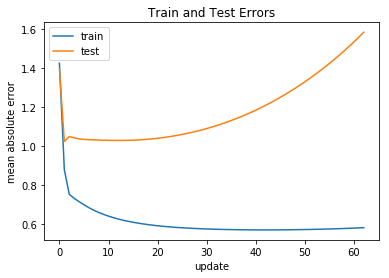

In [35]:
n = len(users)
m = len(movies)
K = 10
lr = .01
show_every = 5
error_threshold = .1
split = .6
max_time = 120

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)

# entries = cells that contain a value in our data matrix
entries = list(zip(*data.nonzero()))
train_entries = entries[:int(len(entries)*split)]
test_entries = entries[int(len(entries)*split):]

def mean_absolute_error(r,p,q,local_entries):
    error = 0
    for (i,j) in local_entries:
        current_error = r[i,j]
        for k in range(K): current_error -= p[i,k]*q[j,k]
        error += abs(current_error)
    return error/len(local_entries)

error_train = mean_absolute_error(data,p,q,train_entries)
error_test = mean_absolute_error(data,p,q,test_entries)
train_errors = [error_train]
test_errors = [error_test]
iter=0
start = time.time()
while error_train > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0:
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        local_error = data[i,j] - sum([p[i,k]*q[j,k] for k in range(K)])
        for k in range(K):
            # updating equations = derivatives of the error per parameter
            p[i,k] += 2*lr*local_error*q[j,k]
            q[j,k] += 2*lr*local_error*p[i,k]
    error_train = mean_absolute_error(data,p,q,train_entries)
    error_test = mean_absolute_error(data,p,q,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
    
#################################################
################ PLOTTING ERRORS ################
#################################################

x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

## Regularization

You can run the code above with different hyper-parameters, but generally, the over-fitting problem is going to persist with sparse matrix factorization. 

What we're going to do is add regularization to the iterative update of our factor matrices, to prevent the numbers from getting too big (and thus limit over-fitting). 


Mean absolute error at iteration 0: (time = 0.00024628639221191406 )
	Train: 1.4514151274391003 	Test: 1.3529529331986674

Mean absolute error at iteration 5: (time = 11.700588464736938 )
	Train: 0.7219107400406665 	Test: 1.0287001844801504

Mean absolute error at iteration 10: (time = 23.48331332206726 )
	Train: 0.6884055097999745 	Test: 1.0266699045961727

Mean absolute error at iteration 15: (time = 35.21373772621155 )
	Train: 0.6520825838507269 	Test: 1.0297118412611765

Mean absolute error at iteration 20: (time = 47.12770199775696 )
	Train: 0.6247983340810327 	Test: 1.0318415764538431

Mean absolute error at iteration 25: (time = 58.81089949607849 )
	Train: 0.6051919923502582 	Test: 1.032449283919952

Mean absolute error at iteration 30: (time = 71.00992488861084 )
	Train: 0.5904257992849028 	Test: 1.0323154859288566

Mean absolute error at iteration 35: (time = 84.61158299446106 )
	Train: 0.5789526605857056 	Test: 1.0319398389876182

Mean absolute error at iteration 40: (time =

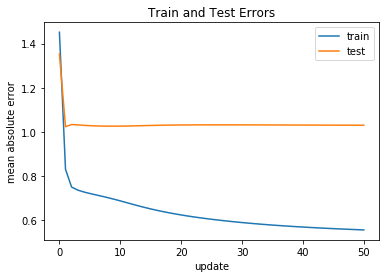

In [32]:
from numpy.linalg import norm
import math

n = len(users)
m = len(movies)
K = 10
lr = .01
show_every = 5
error_threshold = .1
split = .6
max_time = 120

# matrices used for factorization initialized randomly
p = np.random.rand(n,K)
q = np.random.rand(m,K)

# entries = cells that contain a value in our data matrix
entries = list(zip(*data.nonzero()))
train_entries = entries[:int(len(entries)*split)]
test_entries = entries[int(len(entries)*split):]

beta = .02
        
error_train = mean_absolute_error(data,p,q,train_entries)
error_test = mean_absolute_error(data,p,q,test_entries)
train_errors = [error_train]
test_errors = [error_test]
iter=0
start = time.time()
while error_train > error_threshold and time.time()-start<max_time:
    # To see error at each iteration, uncomment:
    if iter%show_every==0: 
        print('\nMean absolute error at iteration',str(iter)+': (time =',time.time()-start,')') 
        print('\tTrain:',error_train,'\tTest:',error_test)
    iter+=1
    for (i,j) in train_entries: 
        local_error = data[i,j] - sum([p[i,k]*q[j,k] for k in range(K)])
        for k in range(K):
            # updating equations = derivatives of the error per parameter
            p[i,k] += lr*(2*local_error*q[j,k]-beta*p[i,k])
            q[j,k] += lr*(2*local_error*p[i,k]-beta*q[j,k])
    error_train = mean_absolute_error(data,p,q,train_entries)
    error_test = mean_absolute_error(data,p,q,test_entries)
    train_errors.append(error_train)
    test_errors.append(error_test)
    
x = range(len(train_errors))
plt.plot(x,train_errors,label='train')
plt.plot(x,test_errors,label='test')
plt.legend()
plt.title('Train and Test Errors')
plt.xlabel('update')
plt.ylabel('mean absolute error')
plt.show()

So the results still aren't quite satisfactory (still 1 point off on average in test), but at least we've put boundaries on over-fitting. 